# Big Tech Stock Predictor

The goal of this project is to use AAPL stock as a tool to leverage different machine learning and deep learning regressors to predict the stock price / movement across an array of intervals to see how accurate ML / DL models can be.

**What is being predicted?**

The predicted feature for this research is the adjusted close as this is the standard for comparing price of a security irregardless of security splits / other external factors, and thus this will be the target feature that the regressors will be trying to estimate.

# Data Pre-Processing

In this step, we are preparing the data to be used in training the models.

Note that feature engineering has already been performed manually on this dataset to add in extra columns, and thus the resulting CSV file is already engineered.

Note also that our target adj close varies depending on the time frame we are trying to predict.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamp from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Linear Regression Model

**Next Day Prediction (non-earnings eve)**

Selects random rows (non-earnings) out of the total test suite of total rows being chosen (consistently 32 since this is the total amount of earnings rows contained in the dataset)

Overall modified Accuracy
0.9731413658359868
Mean Squared Error (adj price in dollars amount off): 2.4104195600316514
Custom Predictions:
[53.79580502]
Accuracy of Custom Prediction:
[95.98535378]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


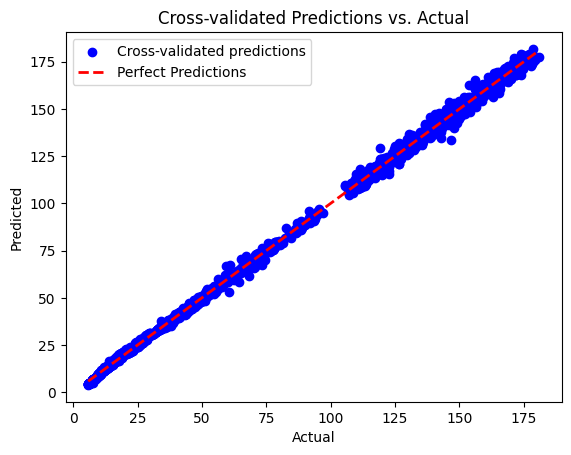

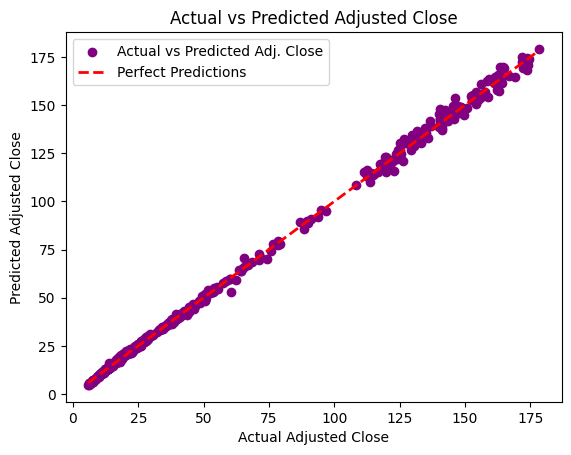

In [4]:
# Shift the 'Adj Close' column to get the target variable for the next day
# that is a non-earnings day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Analysis of non-earnings eve results

In the above graphs, we can see a very interested spread of our model's predictions. In the Actual vs Predicted Adjusted Close graph, we can see that the linear regression model is quite accurate at the start of the actual adjusted close price, but as the adjusted close price goes on (and thus time also increases due to correlation), we see that the model is less accurate with its predictions straying further from the perfect prediction trend line. This phenomena also extends to the accuracy of the cross-validated predictions as well, and can be best explained through the increase of market volatility over recent years.

Market volatility will likely become even more prevalent as time goes on, and thus is something that must be accounted for in making predictions. However, it is interesting that its visualization is so readily obvious in the above graphs.

**Next Day Prediction (earnings eve)**

<ipython-input-6-8199a9ee93eb>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-6-8199a9ee93eb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-6-8199a9ee93eb>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(row)
<ipython-input-6-8199a9ee93eb>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_rows = selected_rows.append(df_aapl.loc[index + 1])
<ipython-input-6-8199a9ee93eb>:10: FutureWarning: The frame.append method is deprecated and will be removed from p

Overall modified Accuracy
0.9629013046006489
Mean Squared Error (adj price in dollars amount off): 14.540673159714526
Custom Predictions:
[53.94843984]
Accuracy of Custom Prediction:
[91.86434598]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


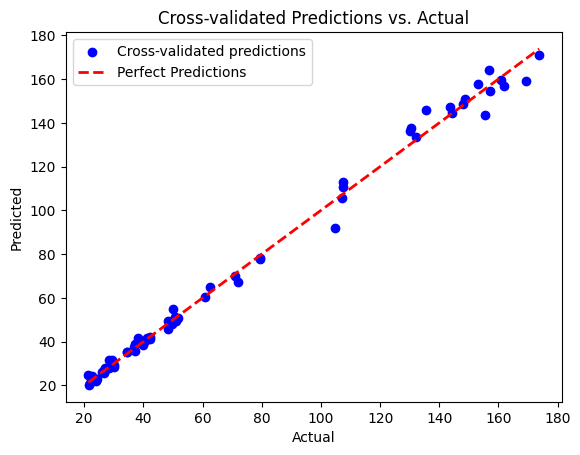

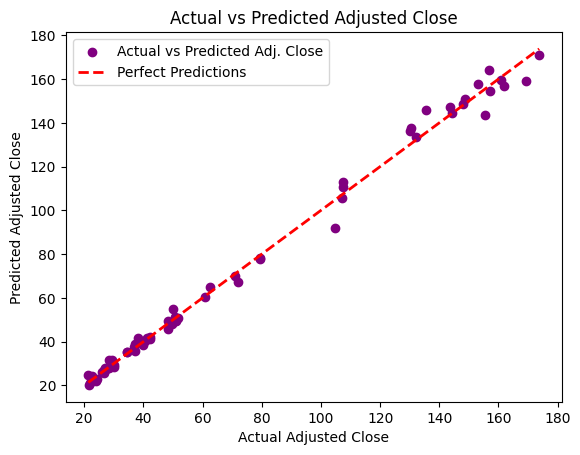

In [6]:
# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        selected_rows = selected_rows.append(row)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          selected_rows = selected_rows.append(df_aapl.loc[index + 1])

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame or list of tuples with predicted and actual values
results_df = pd.DataFrame({'Predicted': predicted, 'Actual': y_aapl})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predicted, y_aapl))

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_aapl, predicted)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print("Custom Predictions:")
print(custom_predictions)

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

# Analysis of earnings eve results

Similar to the above non-earnings eve results, we can see that our linear regression model performs much more accurately when the actual adjusted close price is lower, and becomes more erratic as the share price increases, ie time goes on. Besides having much fewer data points to work with, earnings is particularly interesting as it is readily known that even if a company beats earnings estimates, the stock price can still decrease based on the whims of the market and other external factors, thus, achieving accuracy with the linear regression model for this application is difficult but intriguing. As in recent years past, with increased market volatility we can see this trend demonstrated yet again across both the cross-validated prediction and predicted adjusted close vs actual.

**Next Month Stock Prediction**

**Next Year Stock Prediction**

**Next Decade Stock Prediction**